#  In this notebook, we will compare AdaSSP to NoisyGD

Recall that we have covered SSP and AdaSSP for linear regression the previous notebook.  In this notebook, we will go over the noisy Gradient Descent algorithm that is way more general, and to evaluate its pros and cons. 

This is another notebook with end-to-end experiments and actual implementation of the algorithm.

## We will use the Noisy Gradient Descent algorithm.

Let's say we are minimizing a function $f(\theta)$.  The gradient descent algorithm iteratively run
$$
\theta_{t+1} = \theta_t - \eta_t \nabla f(\theta_t)
$$

Noisy gradient dsecent is a differentially private algorithm which updates the parameters by 
$$
\theta_{t+1} = \theta_t - \eta_t \big(\nabla f(\theta_t) + \textrm{GS}_t \cdot \mathcal{N}(0,\sigma^2 I) \big)
$$
where $\textrm{GS}_t$ is the global sensitivity of $\nabla f(\theta_t)$ as we add/remove individual data points (that contribute to $f$).

For linear regression:
$$f(\theta) = \sum_{i=1}^n(y_i - x_i^T\theta)^2$$

Notice that for NoisyGD, the global sensitivity of $f_t$ depends on $\theta$ and can be calculated by 
$$
\textrm{GS}_t  =  \sup_{x\in\mathcal{X},y\in\mathcal{Y}} \|x(y - x^T\theta_t)\| =  \|\mathcal{X}\|^2\|\theta_t\| + \|\mathcal{X}\|\|\mathcal{Y}\|.
$$

## The underlying DP mechanism for running NoisyGD for ```niter``` iterations is simply:  composition of ```niter``` Gaussian mechanism.


Recall that the standard workflow of autodp is the following:

1. Describe this differentially private mechanism in autodp
2. Calibrate the parameter of this DP mechanism to achieve a pre-defined budget.
2. Implement the algorithm and compare with the non-private baseline on a real dataset.

This is what we are going to do. Before that, we will copy the relevant part of the code on SSP and AdaSSP over to have a baseline of comparison.

## The following four blocks is taken from the SSP vs AdaSSP notebook (you may skip)

Things are covered in these blocks include: Code up SSP / AdaSSP,  Load / preprocess data,  set up experiments.

In [1]:
from autodp.autodp_core import Mechanism
from autodp.mechanism_zoo import ExactGaussianMechanism
from autodp.transformer_zoo import ComposeGaussian

# SSP and AdaSSP

class SSP(Mechanism):
    def __init__(self,sigma1,sigma2,name='SSP'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma1':sigma1,'sigma2':sigma2}
        gm1 = ExactGaussianMechanism(sigma1,name='Release_XTX')
        gm2 = ExactGaussianMechanism(sigma2,name='Release_XTy') 
 
        # compose them with the transformation: ComposeGaussian.
        compose = ComposeGaussian() 
        mech = compose([gm1, gm2 ], [1,1])
        
        # Set all representation to be that of SSP
        self.set_all_representation(mech)

class AdaSSP(Mechanism):
    def __init__(self,sigma1,sigma2,sigma3,name='AdaSSP'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma1':sigma1,'sigma2':sigma2,'sigma3':sigma3}
        gm1 = ExactGaussianMechanism(sigma1,name='Release_XTX')
        gm2 = ExactGaussianMechanism(sigma2,name='Release_XTy') 
        gm3 = ExactGaussianMechanism(sigma3,name='Release_lambdamin') 
 
        # compose them with the transformation: ComposeGaussian.
        compose = ComposeGaussian() 
        mech = compose([gm1, gm2, gm3 ], [1,1,1])
        
        # Set all representation to be that of SSP
        self.set_all_representation(mech)
        
from autodp.calibrator_zoo import eps_delta_calibrator

calibrate = eps_delta_calibrator()

class SSP_scale(SSP):
    def __init__(self,scale,name='SSP'):
        SSP.__init__(self,sigma1=scale*2.0,sigma2=scale*3.0,name=name)

class AdaSSP_scale(AdaSSP):
    def __init__(self,scale,name='AdaSSP'):
        AdaSSP.__init__(self,sigma1=scale*2.0,sigma2=scale*3.0,sigma3=scale*5.0,name=name)
       

In [2]:
# Load data, preprocessing to construct valid bounds.
# Finding non-private baseline

import sklearn.datasets
import numpy as np

dataset = sklearn.datasets.fetch_california_housing()
print('This is a regression dataset.')
print('Features are: ', dataset.feature_names)
print('The label is: ', dataset.target_names)

# Let's extract the relevant information from the sklearn dataset object
X = dataset.data
y = dataset.target
dim = X.shape[1]
n = X.shape[0]

from sklearn import preprocessing

# Rescaling the feature vectors by their natural ranges (independent to the data)
X = X @ np.diag(1./np.array([10,50,100,40,40000,1000,50,100]))
# This is to ensure that each feature is of the similar scale

# the following bounds are chosen independent to the data
x_bound = 1
y_bound = 5

# Preprocess the feature vector such that the norm is fixed at 5
X = x_bound*preprocessing.normalize(X, norm='l2')
# Second, clip label. We also need the labels to be bounded between [0,y_bound]
y = np.clip(y,0,y_bound)

# Now let's construct the sufficient statistics and get the non-private baselines.
XTX = X.T@X
XTy = X.T@y

# Non-private linear regression
theta_nonprivate = np.linalg.solve(XTX,XTy)

# Let's define the performance metric ---  MSE (mean square error) on the training data

def MSE(theta):
    return np.linalg.norm(y - X@theta)**2 / n
 
MSE_nonprivate = MSE(theta_nonprivate)

# Let's also add a trivial baseline for just outputting the mean
MSE_trivial = 1/n*np.linalg.norm(y-np.mean(y))**2

print('The non-private baseline has an MSE of ', MSE_nonprivate)
print('The trivial baseline has an MSE of ', MSE_trivial)


This is a regression dataset.
Features are:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
The label is:  ['MedHouseVal']
The non-private baseline has an MSE of  0.6053084771039058
The trivial baseline has an MSE of  1.331547558951559


In [3]:
# Actual implementation of SSP and AdaSSP

def run_SSP(sigma1,sigma2):
    # GM1
    Z = x_bound**2 * sigma1 * np.random.normal(size=XTX.shape)
    Z_analyzegauss = np.triu(Z) + np.triu(Z,k=1).T 
    hatXTX = XTX +Z_analyzegauss
    
    # GM2
    hatXTy = XTy + x_bound*y_bound * sigma2 * np.random.normal(size=XTy.shape)
    
    theta_ssp = np.linalg.solve(hatXTX,hatXTy)
    return theta_ssp

def run_AdaSSP(sigma1,sigma2,sigma3):
    
    # GM1
    Z = x_bound**2 * sigma1 * np.random.normal(size=XTX.shape)
    Z_analyzegauss = np.triu(Z) + np.triu(Z,k=1).T 
    hatXTX = XTX + Z_analyzegauss
    
    # GM2
    hatXTy = XTy + x_bound*y_bound * sigma2 * np.random.normal(size=XTy.shape)
    
    # GM3
    u,s,vT = np.linalg.svd(XTX)
    
    lambdamin = s[-1] + x_bound**2 * sigma3 * np.random.normal(size=1) 
    
    lambdamin_lowerbound = max(0,lambdamin - x_bound**2 * sigma3*1.96)
    lamb = max(0,np.sqrt(dim) * sigma1 * x_bound**2 * 1.96-lambdamin_lowerbound)
    
    theta_adassp = np.linalg.solve(hatXTX  + lamb*np.eye(dim),hatXTy)
    
    return theta_adassp


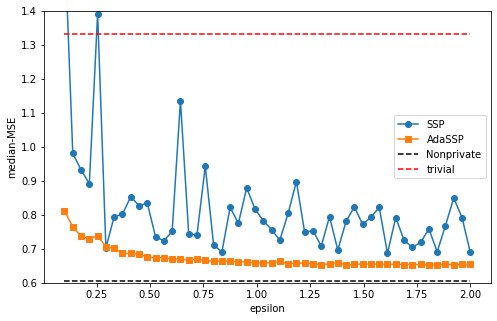

In [4]:
# Run experiments and plot the results

# Run experiments
num = 50
rep = 20

delta_budget = 1e-6
eps_budget_list = np.linspace(0.1,2,num)

# Place holder to save the result.
MSE_list = np.zeros(shape=(num,rep,2))


for i,eps in enumerate(eps_budget_list):
    
    mech_ssp = calibrate(SSP_scale,eps,delta_budget,[0,100])
    mech_adassp = calibrate(AdaSSP_scale,eps,delta_budget,[0,100])
    
    for j in range(rep):
        MSE_list[i,j,0] = MSE(run_SSP(mech_ssp.params['sigma1'],mech_ssp.params['sigma2']))
        MSE_list[i,j,1] = MSE(run_AdaSSP(mech_adassp.params['sigma1'],
                                         mech_adassp.params['sigma2'],
                                         mech_adassp.params['sigma3']))

avg_MSE_list = np.squeeze(np.mean(MSE_list,axis=1))
med_MSE_list = np.squeeze(np.median(MSE_list,axis=1))

# Let's also plot the median
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
plt.plot(eps_budget_list,med_MSE_list[:,0],'o-')
plt.plot(eps_budget_list,med_MSE_list[:,1],'s-')
plt.plot(eps_budget_list,MSE_nonprivate*np.ones(shape=(num,1)),'k--')
plt.plot(eps_budget_list,MSE_trivial*np.ones(shape=(num,1)),'r--')
plt.ylim([0.6,1.4])

plt.legend(['SSP','AdaSSP','Nonprivate','trivial'])
plt.xlabel('epsilon')
plt.ylabel('median-MSE')
plt.show()

## How do these methods compare to NoisyGD?

We will run NoisyGD online and then plot the accuracy and the incurred privacy losses on the same figure.

## 1. Let's first implement NoisyGD from scratch and represent it as a ```Mechanism``` in ```autodp```.

We will start with the autodp representation of NoisyGD, which is a straightforward composition of Gaussian mechanisms. Then we will implement the algorithm itself.

In [5]:
from autodp.mechanism_zoo import GaussianMechanism
from autodp.transformer_zoo import ComposeGaussian


# The autodp Mechanism representation of NoisyGD is the following
class NoisyGD_mech(Mechanism):
    def __init__(self,sigma,coeff,name='NoisyGD'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma':sigma,'coeff':coeff}
        gm = GaussianMechanism(sigma,name='Release_gradient')
        # compose them with the transformation: ComposeGaussian.
        compose = ComposeGaussian() 
        mech = compose([gm], [coeff])
        
        self.set_all_representation(mech)        

        
# Now let's actually implement the noisy gradient descent algorithm

def gradient(theta):
    # the gradient is  sum_i x_i (x_i^T \theta - y)
    # It has a global sensitivity of x_bound^2\|theta\|_2 + x_bound * y_bound
    # in matrix form it is the following
    return XTX@theta - XTy

def run_NoisyGD_step(theta,sigma, lr):
    GS = x_bound**2 * np.linalg.norm(theta) + x_bound * y_bound
    return theta - lr * (gradient(theta)  + GS*sigma*np.random.normal(size=theta.shape))

# function to run NoisyGD 
def run_NoisyGD(sigma,lr,niter, log_gap = 10):
    theta_GD = np.zeros_like(theta_nonprivate)
    MSE_GD = []
    eps_GD = []
    for i in range(niter):
        theta_GD = run_NoisyGD_step(theta_GD,sigma, lr)
        if not i%log_gap:    
            mech = NoisyGD_mech(sigma,i+1)
            eps_GD.append(mech.approxDP(delta))
            MSE_GD.append(MSE(theta_GD))
    return MSE_GD, eps_GD


## 2. How do we choose the hyperparameters for NoisyGD?

Our strategy of choosing this hyperparameter is to first set the noise level and the number of iterations. (We can alternatively fix one of these and use autodp's privacy calibrator to determine the other.)  

Once we decide on the noise level and the number of iterations, we will choose the learning rate by the optimal theoretical choice.  It requires a data-dependent quantity (the gradient lipschitz constant is the largest eigenvalue of $X^TX$) which we wave our hand  (ideally we can also privately release it at a small additional cost).


In [6]:
from autodp.calibrator_zoo import eps_delta_calibrator

def find_appropriate_niter(sigma, eps,delta):
    # Use autodp calibrator for selecting 'niter'
    NoisyGD_fix_sigma = lambda x:  NoisyGD_mech(sigma,x)
    calibrate = eps_delta_calibrator()
    mech = calibrate(NoisyGD_fix_sigma, eps, delta, [0,100000])
    niter = int(np.floor(mech.params['coeff']))
    return niter

def theoretical_lr_choice(L,dim,sigma,niter):
    # L is the gradient lipschitz constant, sigma is the variance of the gradient noise in each coordinate
    # niter is the intended number of iterations (the LR is optimized for the point we get when finishing all niter)
    return np.minimum(1/L,4/np.sqrt(dim*sigma*lambdamax*niter))



## Now let's run some experiments and plot the results!

We will first compare two regimes:  
1. large noise, large number of iterations, small learning rate; 
2. small noise, small number of iterations, large learning rate.

In [7]:
# Large noise
sigma = 500.0
eps = 2.0
delta = 1e-6
niter = find_appropriate_niter(sigma, eps,delta)

print(niter)

#niter = 50000 # 

# find the theoretical learning rate choice by first working out the strong smoothness property
u,s,vT = np.linalg.svd(XTX)    
lambdamax = s[0]
# find an estimated data-independent typical GS (actual GS is chosen on the fly)
GS = x_bound**2 * 1 + x_bound*y_bound

lr = theoretical_lr_choice(lambdamax,dim,sigma*GS,niter)
#lr = np.minimum(1/lambdamax,np.sqrt(2)/np.sqrt(dim*sigma*lambdamax*niter))
# Theoretical choice for GD  (those this is giving GD a bit of unfair advantage because lambdamax is data-dependent)
# For a more data-independent choice, one can use x_bound**2 * n,   though n is also data-dependent.
MSE_GD1, eps_GD1 = run_NoisyGD(sigma,lr,niter,log_gap=100)

# Small noise
sigma = 50
niter = find_appropriate_niter(sigma, eps,delta)
print(niter)
# niter = 500
lr = theoretical_lr_choice(lambdamax,dim,sigma*GS,niter)
MSE_GD2, eps_GD2 = run_NoisyGD(sigma,lr,niter)


50251
502


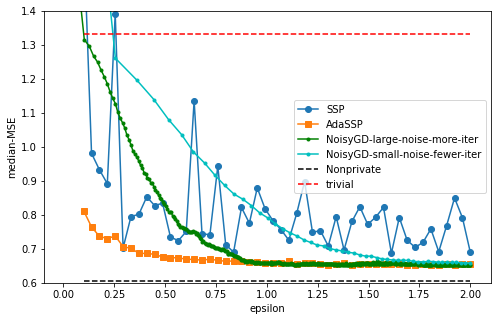

In [8]:
# Let's also plot the results
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
plt.plot(eps_budget_list,med_MSE_list[:,0],'o-')
plt.plot(eps_budget_list,med_MSE_list[:,1],'s-')
plt.plot(eps_GD1, MSE_GD1,'g.-')
plt.plot(eps_GD2, MSE_GD2,'c.-')
plt.plot(eps_budget_list,MSE_nonprivate*np.ones(shape=(num,1)),'k--')
plt.plot(eps_budget_list,MSE_trivial*np.ones(shape=(num,1)),'r--')
plt.ylim([0.6,1.4])

plt.legend(['SSP','AdaSSP','NoisyGD-large-noise-more-iter','NoisyGD-small-noise-fewer-iter','Nonprivate','trivial'])
plt.xlabel('epsilon')
plt.ylabel('median-MSE')
plt.show()

So as we can see, the large-noise + more-iteration choice seems to converge faster on the epsilon scale, though they both arrive at very similar places towards the end of the training.

## What if we wiggle the learning rate for a bit?

Next,  we will consider the stability of the learning rate choices by trying larger and smaller learning rate near the theoretical choice:

3. Multiplying the learning rate by 10
4. Dividing the learning rate by 10

In [9]:
sigma = 500.0

u,s,vT = np.linalg.svd(XTX)    
lambdamax = s[0]
niter = 50000

lr = 10*theoretical_lr_choice(lambdamax,dim,sigma*GS,niter)
# Theoretical choice for GD  (those this is giving GD a bit of unfair advantage because lambdamax is data-dependent)

MSE_GD3, eps_GD3 = run_NoisyGD(sigma,lr,niter,log_gap=100)

lr = 0.1*theoretical_lr_choice(lambdamax,dim,sigma*GS,niter)
# Theoretical choice for GD  (those this is giving GD a bit of unfair advantage because lambdamax is data-dependent)

MSE_GD4, eps_GD4 = run_NoisyGD(sigma,lr,niter,log_gap=100)


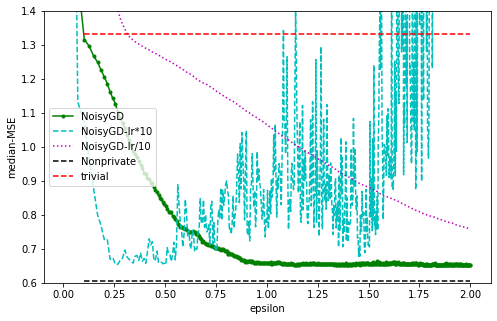

In [10]:
# Let's also plot the median
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
# plt.plot(eps_budget_list,med_MSE_list[:,0],'o-')
# plt.plot(eps_budget_list,med_MSE_list[:,1],'s-')
plt.plot(eps_GD1, MSE_GD1,'g.-')
plt.plot(eps_GD3, MSE_GD3,'c--')
plt.plot(eps_GD4, MSE_GD4,'m:')
plt.plot(eps_budget_list,MSE_nonprivate*np.ones(shape=(num,1)),'k--')
plt.plot(eps_budget_list,MSE_trivial*np.ones(shape=(num,1)),'r--')
plt.ylim([0.6,1.4])

plt.legend(['NoisyGD','NoisyGD-lr*10','NoisyGD-lr/10','Nonprivate','trivial'])
plt.xlabel('epsilon')
plt.ylabel('median-MSE')
plt.show()

## Conclusion

Noisy Gradient Descent is a very competitive algorithm especially when we tune its hyperparameter accurately.  Sometimes it requires data-dependent choices, which could be chosen differentially privately at an additional privacy cost.  Specifically, we find that:

1. Using larger noise and many iterations help NoisyGD to perform competitively. 
2. The algorithm is somewhat sensitive to the choice of the learning rate, and it may either converge slowly or diverge if not chosen appropriately. 

Overall, for linear regression, I find AdaSSP is still the preferred algorithm. However NoisyGD is a more general algorithm that can be applied to even deep learning.  We see that with appropriately chosen hyperparameters, NoisyGD enjoys some strong adaptivity (e.g., no need to have a bound on $\theta$), also it converges faster when the data are good almost for free.

In terms of privacy accounting and privacy calibration.  The use of ```autodp``` makes it very straightforward to get exactly optimal privacy loss or parameters to achieve a certain privacy budgets for these examples, which could fit into most workflows very easily.  